In [1]:
import pandas as pd
import numpy as np

entities=pd.read_csv("../../metakg-reorg/data/extract_data/metakg_entities.csv")
triples=pd.read_csv("../../metakg-reorg/data/extract_data/metakg_triples.csv")


In [36]:
list(triples["Relationship"].unique())

['is_a',
 'has_pathway',
 'has_pathway_class',
 'related_to_pathway',
 'related_to_gene',
 'has_uniprot_id',
 'has_reaction',
 'is a',
 'has_enzyme',
 'same as',
 'has_module',
 'has_network',
 'has_substrate',
 'has_reference',
 'belongs_to_orthology',
 'has_product',
 'related_to_genes',
 'belongs_to_reaction_class',
 'has_compound',
 'belongs_to_network',
 'has_drug',
 'has_disposition',
 'has_process',
 'has_role',
 'chemical_formula',
 'related_to_protein',
 'has_disease',
 'has_predicted_property',
 'has_substituent',
 'average_molecular_weight',
 'has_alternative_class',
 'has_inchi',
 'has_synonym',
 'has_smiles',
 'has_kingdom',
 'has_inchikey',
 'has_class',
 'has_molecular_framework',
 'has_description',
 'same_as',
 'has_cellular_location',
 'has_status',
 'has_name',
 'has_biospecimen_location',
 'has_external_descriptor',
 'has_pubchem_id',
 'has_state',
 'has_tissue_location',
 'has_upper_concentration_in',
 'has_chebi_id',
 'has_normal_concentration_in',
 'has_kegg_id',

In [31]:
import pandas as pd
import numpy as np
from pyecharts import options as opts
from pyecharts.charts import Sankey
from pyecharts.globals import ThemeType
from collections import defaultdict
import random

hmdb_list=['hmdb_id:HMDB0001308','hmdb_id:HMDB0062800','hmdb_id:HMDB0001341','hmdb_id:HMDB0000208','hmdb_id:HMDB0062424','hmdb_id:HMDB0014559','hmdb_id:HMDB0000168','hmdb_id:HMDB0000191','hmdb_id:HMDB0000538','hmdb_id:HMDB0000562','hmdb_id:HMDB0000082','hmdb_id:HMDB0001532','hmdb_id:HMDB0000998','hmdb_id:HMDB0000012','hmdb_id:HMDB0001112','hmdb_id:HMDB0001473','hmdb_id:HMDB0001068','hmdb_id:HMDB0001342','hmdb_id:HMDB0001409','hmdb_id:HMDB0001058','hmdb_id:HMDB0001049','hmdb_id:HMDB0001201','hmdb_id:HMDB0008327','hmdb_id:HMDB0001397','hmdb_id:HMDB0003379','hmdb_id:HMDB0015536','hmdb_id:HMDB0000172','hmdb_id:HMDB0000156','hmdb_id:HMDB0002108','hmdb_id:HMDB0001138','hmdb_id:HMDB0006029','hmdb_id:HMDB0011745','hmdb_id:HMDB0001487','hmdb_id:HMDB0000217','hmdb_id:HMDB0000828','hmdb_id:HMDB0250791','hmdb_id:HMDB0001489','hmdb_id:HMDB0000618','hmdb_id:HMDB0029418','hmdb_id:HMDB0060274','hmdb_id:HMDB0000251','hmdb_id:HMDB0000295','hmdb_id:HMDB0000286','hmdb_id:HMDB0000290','hmdb_id:HMDB0000285']
select_relations = ['has_pathway', 'has_disease', 'has_reference', 'has_tissue_location', "has_class"]
num_relations_to_select = 10

def create_sankey_plot(triples, select_relations, hmdb_list, num_relations_to_select):

    triples = triples[triples["Relationship"].isin(select_relations)]

    def prepare_sankey_data(triples, category):
        nodes = set()
        links = []
        
        for _, row in triples.iterrows():
            if row['Head'].startswith('hmdb_id:'):
                source = row['Head']
                target = f"{category}:{row['Tail']}"
            else:
                source = f"{category}:{row['Head']}"
                target = row['Tail']
            
            nodes.add(source)
            nodes.add(target)
            links.append({"source": source, "target": target, "value": 1})
        
        return list(nodes), links

    num_relations_to_select = 10
    all_nodes = set()
    all_links = []

    for relation in select_relations:
        relation_triples = triples[(triples["Relationship"] == relation) & 
                                ((triples["Head"].isin(hmdb_list)) | (triples["Tail"].isin(hmdb_list)))]
        top_n_relation = relation_triples[relation_triples["Tail"].isin(relation_triples["Tail"].value_counts().index[:num_relations_to_select])]
        nodes, links = prepare_sankey_data(top_n_relation, relation)
        all_nodes.update(nodes)
        all_links.extend(links)

    metabolite_values = defaultdict(int)
    for link in all_links:
        if link["source"].startswith("hmdb_id:"):
            metabolite_values[link["source"]] += link["value"]

    project_node = "project_id:001"
    all_nodes.add(project_node)
    metabolite_nodes = [node for node in all_nodes if node.startswith("hmdb_id:")]
    for metabolite in metabolite_nodes:
        all_links.append({"source": project_node, "target": metabolite, "value": metabolite_values[metabolite]})

    def get_color_palette():
        return [
            "#4ECDC4",  
            "#FF6F61",  
            "#6A5ACD",  
            "#FFB400",  
            "#FF6F91",  
            "#1A1A1D",  
            "#F7B7A3",  
            "#C7D2FE",  
            "#FF9A00",  
            "#A0D9CE"   
        ]

    color_palette = get_color_palette()

    categories = ["project_id", "hmdb_id"] + select_relations
    color_map = {category: color_palette[i % len(color_palette)] for i, category in enumerate(categories)}


    nodes = []
    for node in all_nodes:
        category = node.split(":")[0] if ":" in node else "hmdb_id"
        nodes.append({"name": ":".join(node.split(":")[-2:]), "itemStyle": {"color": color_map[category]}})

    for link in all_links:
        target_category = link["target"].split(":")[0] if ":" in link["target"] else "hmdb_id"
        link["target"]=":".join(link["target"].split(":")[-2:]) if ":" in link["target"] else link["target"]
        link["lineStyle"] = {"color": color_map[target_category]}

    sankey = Sankey(init_opts=opts.InitOpts(width="1200px", height="800px", theme=ThemeType.LIGHT))

    for category, color in color_map.items():
        sankey.add(
            series_name=category,
            nodes=[],
            links=[],
            label_opts=opts.LabelOpts(color=color),
            linestyle_opt=opts.LineStyleOpts(opacity=0.3, curve=0.5, color=color),
            itemstyle_opts=opts.ItemStyleOpts(color=color),
        )

    sankey.add(
        series_name="Metabolite Relationships",
        nodes=nodes,
        links=all_links,
        linestyle_opt=opts.LineStyleOpts(opacity=0.2, curve=0.5),
        label_opts=opts.LabelOpts(position="right"),
        node_gap=4,
    )

    sankey.set_global_opts(
        title_opts=opts.TitleOpts(title="Metabolite Relationships Sankey Diagram"),
        tooltip_opts=opts.TooltipOpts(trigger="item", trigger_on="mousemove"),
        legend_opts=opts.LegendOpts(
            orient="horizontal",
            pos_left="30%",
            pos_top="top",
            item_width=20,
            item_height=15,
            textstyle_opts=opts.TextStyleOpts(font_size=12),
        )
    )

    sankey.render("metabolite_relationships_sankey.html")

In [20]:
import time
start_time = time.time()
create_sankey_plot(triples, select_relations, hmdb_list, num_relations_to_select)
end_time = time.time()

runtime = end_time - start_time
runtime

2.6393678188323975

select_relations_num: 1, avg_runtime: 0.42012557983398435, 95% CI: [0.272782718322829, 0.5674684413451396]
select_relations_num: 2, avg_runtime: 0.7780145406723022, 95% CI: [0.678022868023853, 0.8780062133207515]
select_relations_num: 3, avg_runtime: 1.5172157764434815, 95% CI: [1.346148931785013, 1.68828262110195]
select_relations_num: 4, avg_runtime: 1.9331828594207763, 95% CI: [1.7927669548344851, 2.0735987640070674]
select_relations_num: 5, avg_runtime: 2.5365611791610716, 95% CI: [2.5093823409413223, 2.563740017380821]
num_relations_to_select: 2, avg_runtime: 2.4881832122802736, 95% CI: [2.480640280330465, 2.4957261442300824]
num_relations_to_select: 4, avg_runtime: 2.491869878768921, 95% CI: [2.4819778700350965, 2.5017618875027456]
num_relations_to_select: 6, avg_runtime: 2.4932772636413576, 95% CI: [2.484369556221814, 2.502184971060901]
num_relations_to_select: 8, avg_runtime: 2.5027118921279907, 95% CI: [2.4929132373157152, 2.512510546940266]
num_relations_to_select: 10, avg_ru

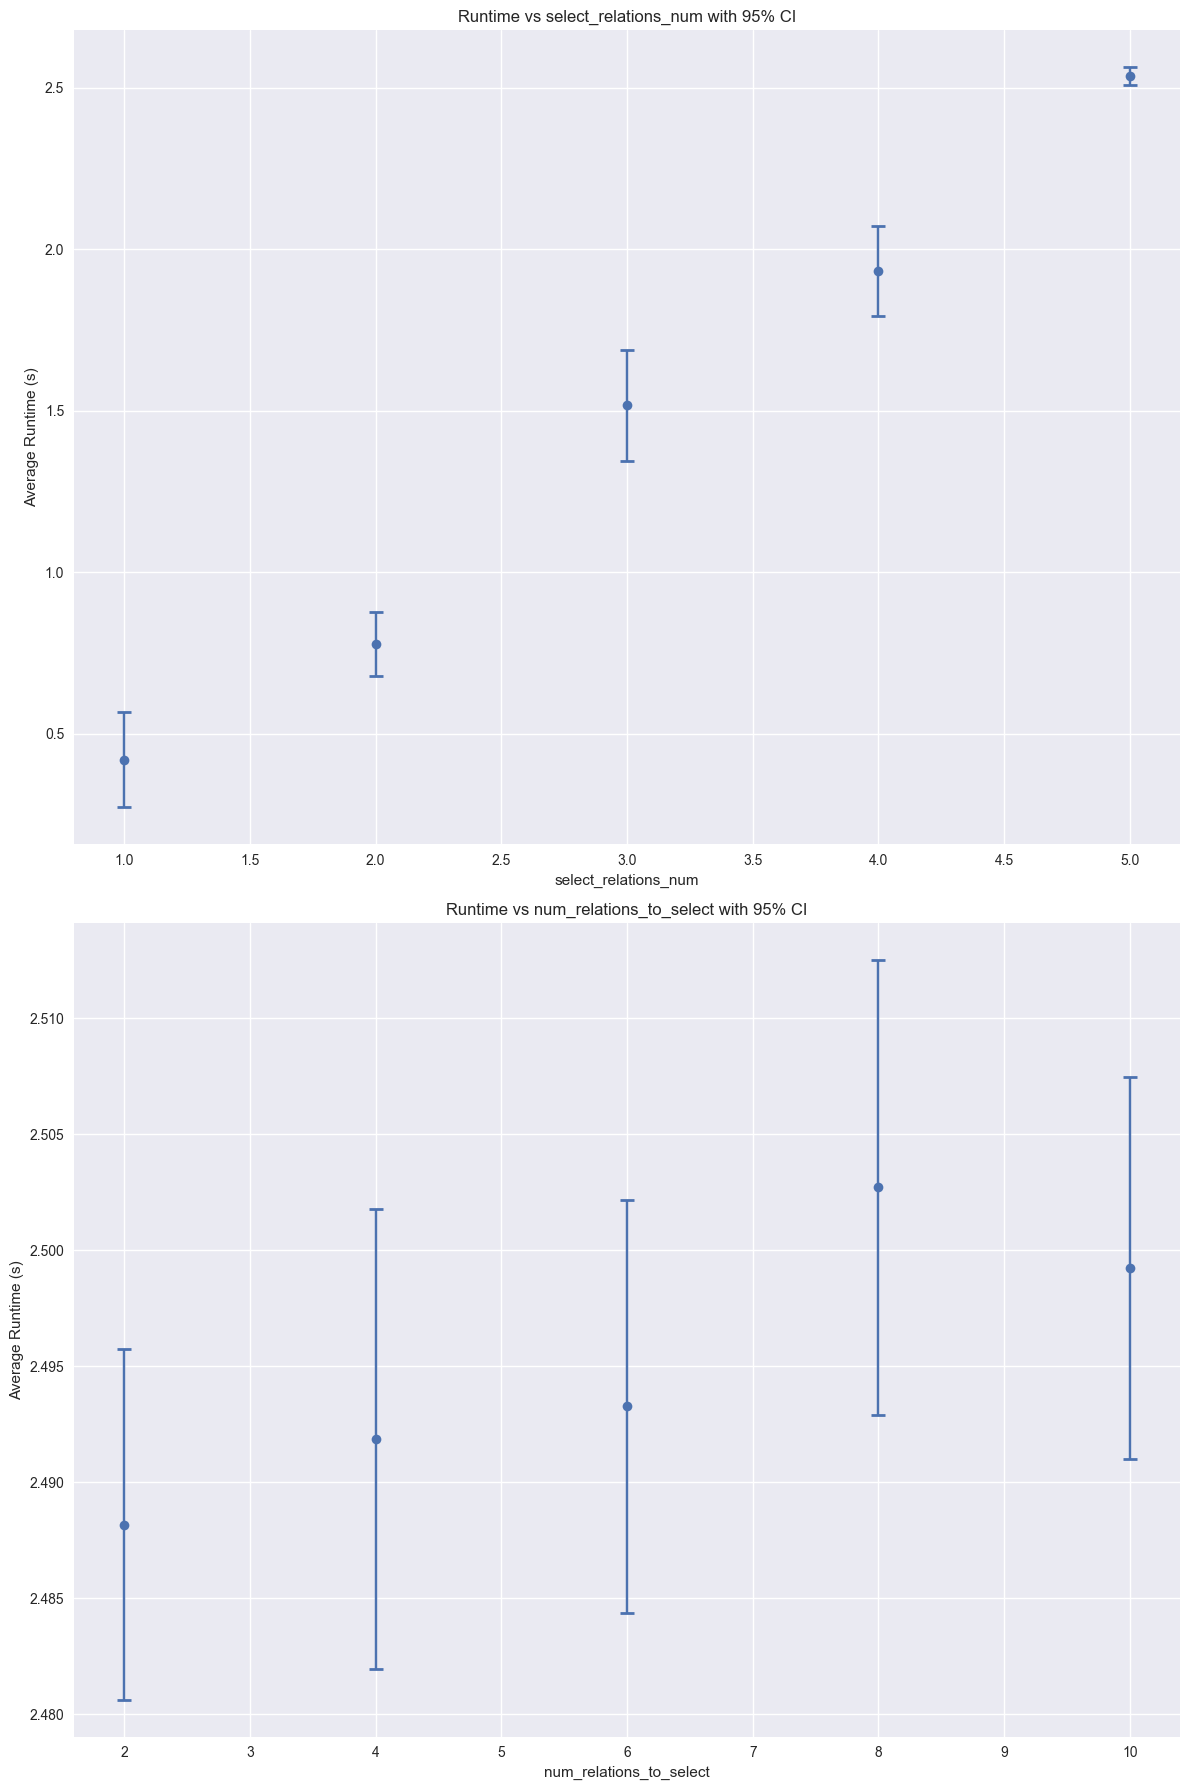

In [44]:
import time
import random
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

runtime_data = {
    "select_relations_num": [],
    "hmdb_list_num": [],
    "num_relations_to_select": [],
    "avg_runtime": [],
    "ci_lower": [],
    "ci_upper": []
}

for select_relations_num in [1, 2, 3, 4, 5]:
    runtimes = []
    for _ in range(10):
        select_relations_new = random.sample(select_relations, select_relations_num)
        start_time = time.time()
        create_sankey_plot(triples, select_relations_new, hmdb_list[:45], 10)
        end_time = time.time()
        runtime = end_time - start_time
        runtimes.append(runtime)
    avg_runtime = np.mean(runtimes)
    std_error = np.std(runtimes, ddof=1) / np.sqrt(len(runtimes))
    ci_lower, ci_upper = norm.interval(0.95, loc=avg_runtime, scale=std_error)
    runtime_data["select_relations_num"].append(select_relations_num)
    runtime_data["avg_runtime"].append(avg_runtime)
    runtime_data["ci_lower"].append(ci_lower)
    runtime_data["ci_upper"].append(ci_upper)
    print(f"select_relations_num: {select_relations_num}, avg_runtime: {avg_runtime}, 95% CI: [{ci_lower}, {ci_upper}]")

for num_relations_to_select in [2, 4, 6, 8, 10]:
    runtimes = []
    for _ in range(10):
        start_time = time.time()
        create_sankey_plot(triples, select_relations[:5], hmdb_list[:45], num_relations_to_select)
        end_time = time.time()
        runtime = end_time - start_time
        runtimes.append(runtime)
    avg_runtime = np.mean(runtimes)
    std_error = np.std(runtimes, ddof=1) / np.sqrt(len(runtimes))
    ci_lower, ci_upper = norm.interval(0.95, loc=avg_runtime, scale=std_error)
    runtime_data["num_relations_to_select"].append(num_relations_to_select)
    runtime_data["avg_runtime"].append(avg_runtime)
    runtime_data["ci_lower"].append(ci_lower)
    runtime_data["ci_upper"].append(ci_upper)
    print(f"num_relations_to_select: {num_relations_to_select}, avg_runtime: {avg_runtime}, 95% CI: [{ci_lower}, {ci_upper}]")

fig, ax = plt.subplots(2, 1, figsize=(12, 18))

ax[0].errorbar(runtime_data["select_relations_num"], runtime_data["avg_runtime"][:5],
               yerr=[np.subtract(runtime_data["avg_runtime"][:5], runtime_data["ci_lower"][:5]),
                     np.subtract(runtime_data["ci_upper"][:5], runtime_data["avg_runtime"][:5])],
               fmt='o', capsize=5, capthick=2)
ax[0].set_title('Runtime vs select_relations_num with 95% CI')
ax[0].set_xlabel('select_relations_num')
ax[0].set_ylabel('Average Runtime (s)')

ax[1].errorbar(runtime_data["num_relations_to_select"], runtime_data["avg_runtime"][5:],
               yerr=[np.subtract(runtime_data["avg_runtime"][5:], runtime_data["ci_lower"][5:]),
                     np.subtract(runtime_data["ci_upper"][5:], runtime_data["avg_runtime"][5:])],
               fmt='o', capsize=5, capthick=2)
ax[1].set_title('Runtime vs num_relations_to_select with 95% CI')
ax[1].set_xlabel('num_relations_to_select')
ax[1].set_ylabel('Average Runtime (s)')

plt.tight_layout()
plt.show()

/var/folders/14/0j3n_yrd7n39gvsnq44p9f4r0000gn/T/ipykernel_63935/1470104377.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


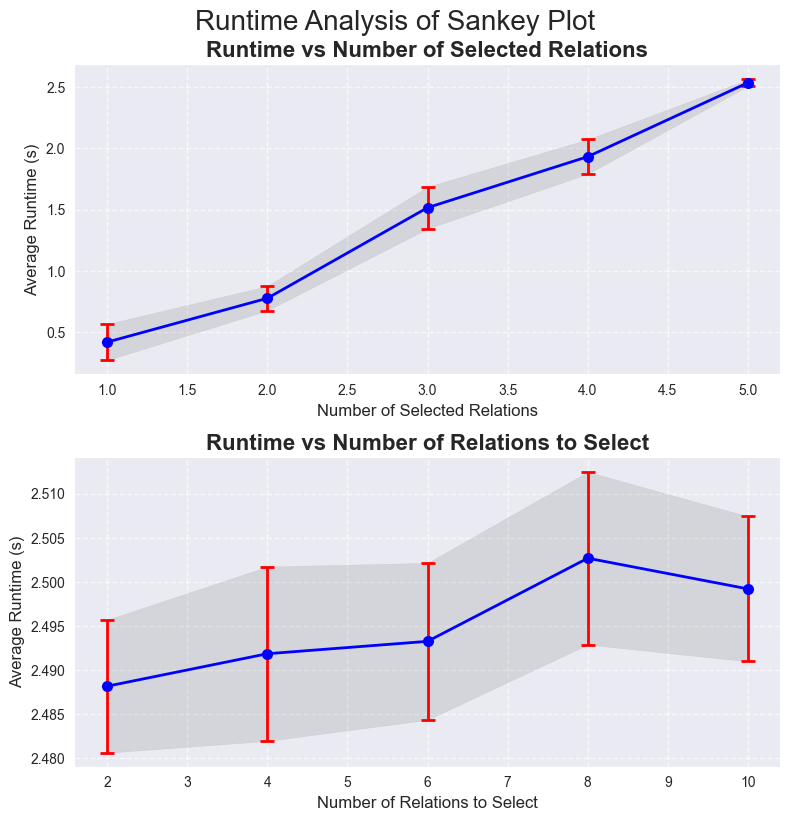

In [46]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('seaborn')

fig, axs = plt.subplots(2, 1, figsize=(8, 8))

def plot_runtime(ax, x_data, y_data, ci_lower, ci_upper, x_label, title):
    ax.errorbar(x_data, y_data, 
                yerr=[np.subtract(y_data, ci_lower), 
                      np.subtract(ci_upper, y_data)],
                fmt='o-', capsize=5, capthick=2, ecolor='red', color='blue', 
                linewidth=2, markersize=8)
    ax.fill_between(x_data, ci_lower, ci_upper, alpha=0.2, color='gray')
    ax.set_title(title, fontsize=16, fontweight='bold')
    ax.set_xlabel(x_label, fontsize=12)
    ax.set_ylabel('Average Runtime (s)', fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.7)
    
# Plot for select_relations_num
plot_runtime(axs[0], 
             runtime_data["select_relations_num"], 
             runtime_data["avg_runtime"][:5],
             runtime_data["ci_lower"][:5],
             runtime_data["ci_upper"][:5],
             'Number of Selected Relations',
             'Runtime vs Number of Selected Relations')

# Plot for num_relations_to_select
plot_runtime(axs[1], 
             runtime_data["num_relations_to_select"], 
             runtime_data["avg_runtime"][5:],
             runtime_data["ci_lower"][5:],
             runtime_data["ci_upper"][5:],
             'Number of Relations to Select',
             'Runtime vs Number of Relations to Select')

plt.tight_layout()
fig.suptitle('Runtime Analysis of Sankey Plot', fontsize=20, y=1.02)

plt.show()